In [ ]:
import os
import random
import glob
import cv2
import shutil
import subprocess

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa 
import matplotlib.pyplot as plt

from tensorflow import keras
from PIL import ImageFile

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import Xception 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Предварительная обработка набора данных

In [ ]:
# Считываем данные

df = pd.read_csv('./train.csv')

In [ ]:
df

,guid,description,typology
0,c84c547b-c5c5-45cf-9199-736df1301124,Монета. Екатерина II. Две копейки. 1789 г.,предметы нумизматики
1,af6fb03f-3d31-484f-ba9d-51e7b4ef55b9,Владельческий конволют. Собрание сочинений. / ...,редкие книги
2,5ad52d30-8239-4b41-bd56-da99ab5a555b,"Медаль ВДНХ ""За успехи в народном хозяйстве СС...",предметы нумизматики
3,6ce2ecbe-80d2-45d1-8a4c-7599950a7792,Монета. Михаил Федорович. Копейка,предметы нумизматики
4,73a48c2d-12c3-40da-b071-f9abd5bed64b,Временное удостоверение №12849 Охотина Р.А. о ...,документы
...,...,...,...
4730,5b9b91be-8d26-4d35-a518-7dda124d3dfb,Открытка В. Маяковский. «Владимир Ильич Ленин»...,предметы печатной продукции
4731,0f6b203b-511d-4a63-97ab-f5d9b38e595e,"Знак ""Отличник Всесоюзного социалистического с...",предметы нумизматики
4732,2d09c446-86be-4bad-83ca-d08b07285312,Монета. 15 копеек,предметы нумизматики
4733,371edf1f-900b-4821-89c2-4e15ac40a12d,"Журнал. ""Огонёк"".- 1928.- №14.",предметы печатной продукции


In [ ]:
# Пропуск битых/усеченных изображений + снимаем ограничения по размерам изображений

ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 1000000000

In [ ]:
# Распределение изображений по каталогам

foto_shape = []
foto_enpology = []
foto_name = []
foto_error = []

for i in range(0,15):
  for foto in os.listdir(f'./typology/{i}'):
    img=cv2.imread(f'./typology/{i}/{foto}')
    print(i, foto)
    foto_name.append(f'{foto}')
    foto_enpology.append(i)
    try:
      foto_shape.append(img.shape[0])
    except Exception:
      print(foto, foto, foto)
      foto_error.append([i, f'{foto}'])

In [ ]:
# В первых 3 каталогах есть битые изображения, которые пропустили на предыдущем шаге

for i in range(0, 2):
  for foto in os.listdir(f'./typology/{i}'):
    img=cv2.imread(f'./typology/{i}/{foto}')
    if foto == foto_error[1]:
      os.remove(img)
      print(f'delete{img}')

In [ ]:
# Аугментация + преобразование изображения в массив

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    './typology',
    target_size=(299, 299),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
  )

Found 7299 images belonging to 15 classes.


#Готовим модель Xception

In [ ]:
# Задаем переменные для будущей модели

FAST_RUN = False
IMAGE_WIDTH=299
IMAGE_HEIGHT=299
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
# Создаем экземпляр архитектуры Xception.

tf.keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

91889664/91884032 [==============================] - 2s 0us/step


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/museum/Xception/',
    save_weights_only=True,
    monitor='f1_score',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_head = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/museum/Xception/',
    save_weights_only=True,
    monitor='f1_score',
    mode='max',
    save_best_only=True)


In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 679 kB 15.3 MB/s 


In [ ]:
f1 = tfa.metrics.F1Score(num_classes=15,  average="macro")

In [ ]:
base_model = Xception(weights='imagenet', include_top=False)

x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = BatchNormalization()(x)
x = Dense(500, activation='tanh')(x) 
x = Dropout(0.2)(x) 
# x = Dense(250, activation='tanh')(x) 
# x = Dropout(0.2)(x) 
# x = Dense(128, activation='tanh')(x) 
# x = Dropout(0.2)(x) 
# x = Dropout(0.1)(x) 
predictions = Dense(15, activation='softmax')(x)

opt = keras.optimizers.Adam(learning_rate=0.0001)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

#f1=tfa.metrics.F1Score(num_classes=15,  threshold=0.5)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=15, threshold=0.5)])  

model.fit(train_generator, epochs=5)#, callbacks=[model_checkpoint_callback_head])

for layer in model.layers[:30]:
   layer.trainable = False
for layer in model.layers[30:]:
   layer.trainable = True


model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=15,  average="macro")])

model.fit(train_generator, epochs=20) #, callbacks=[model_checkpoint_callback])

model.save('./Xception')
model.save_weights('./my_model_weights.h5')

Epoch 1/5
115/115 [==============================] - 959s 8s/step - loss: 1.8139 - f1_score: 0.3645
Epoch 2/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


115/115 [==============================] - 339s 3s/step - loss: 1.2881 - f1_score: 0.5533
Epoch 3/5
115/115 [==============================] - 342s 3s/step - loss: 1.1535 - f1_score: 0.5980
Epoch 4/5
115/115 [==============================] - 342s 3s/step - loss: 1.0668 - f1_score: 0.6305
Epoch 5/5
115/115 [==============================] - 339s 3s/step - loss: 0.9951 - f1_score: 0.6487
Epoch 1/20
115/115 [==============================] - 351s 3s/step - loss: 1.1914 - f1_score: 0.6305
Epoch 2/20
115/115 [==============================] - 352s 3s/step - loss: 0.5968 - f1_score: 0.8110
Epoch 3/20
115/115 [==============================] - 362s 3s/step - loss: 0.3679 - f1_score: 0.8823
Epoch 4/20
115/115 [==============================] - 354s 3s/step - loss: 0.2338 - f1_score: 0.9299
Epoch 5/20
115/115 [==============================] - 352s 3s/step - loss: 0.1938 - f1_score: 0.9400
Epoch 6/20
115/115 [==============================] - 349s 3s/step - loss: 0.1379 - f1_score: 0.9619
Epoc

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/museum/Xception/assets


In [ ]:
load_model = tf.keras.models.load_model
model = load_model('./Xception/', custom_objects={'f1_score':f1})
model

In [ ]:
# history = model.fit(train_generator, 
#                     epochs=50, )
#                     #callbacks=[model_checkpoint_callback])

# model.save('/content/drive/MyDrive/museum/Xception')
# model.save_weights('/content/drive/MyDrive/museum/Xception/my_model_weights.h5')

# Получаем и анализируем результат классификации

In [ ]:
def img_preproccessing(photo_path):
    img = Image.open(photo_path)
    max_size = max(img.size)
    new_size = (max_size, max_size)
    new_im = Image.new("RGB", new_size)
    new_im.paste(img, (round((new_size[0]-img.size[0])/2),round((new_size[1]-img.size[1])/2)))
    new_im = new_im.resize((64,64))
    _img_arr = img_to_array(new_im)  # Numpy array with shape (299, 299, 3)
    _img_arr = _img_arr.reshape((1,) + _img_arr.shape)  # Numpy array with shape (1, 299, 299, 3)
    _img_arr /= 255 # Rescale by 1/255
    return _img_arr

In [ ]:
# Формирование словаря с присвоенными класcами и наименование класса

d = {
    0: 'графика',
    1: 'документы',
    2: 'живопись',
    3: 'оружие',
    4: 'предметы археологии',
    5: 'предметы естественнонаучной коллекции',
    6: 'предметы минералогической коллекции',
    7: 'предметы нумизматики',
    8: 'предметы печатной продукции',
    9: 'предметы прикладного искусства, быта и этнографии',
    10: 'предметы техники',
    11: 'прочие',
    12: 'редкие книги',
    13: 'скульптура',
    14: 'фотографии и негативы' ,   
}

topology = d

In [ ]:
preds = model.predict(img_preproccessing('./f5961467-b2d9-44cc-b618-8d27700ae9fe.jpg')) 
preds

array([[5.42845111e-03, 5.44438325e-02, 1.32822315e-05, 4.71755222e-04,
        8.18835665e-03, 1.27841653e-02, 1.53572690e-02, 2.17182236e-03,
        8.38627515e-04, 8.05182680e-02, 5.20824969e-01, 2.95394450e-01,
        1.86645624e-03, 2.24296018e-05, 1.67592231e-03]], dtype=float32)

In [ ]:
def decoder(d, preds):
  preds = preds.tolist()
  return max(list(zip(*preds, d.values())))

In [ ]:
decoder(d, preds)

(0.5208249688148499, 'предметы техники')

In [ ]:
model.predict(img_preproccessing('/content/drive/MyDrive/museum/f5961467-b2d9-44cc-b618-8d27700ae9fe.jpg'))

array([[1.2309844e-01, 8.1693709e-01, 5.6228682e-04, 1.3655212e-03,
        8.6829983e-05, 7.8341328e-03, 1.0204144e-03, 7.4218432e-03,
        2.5419898e-03, 9.1758464e-04, 2.5108561e-03, 1.2064937e-03,
        8.9415805e-03, 2.3284541e-02, 2.2703442e-03]], dtype=float32)

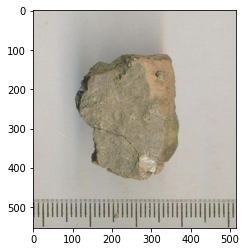

In [ ]:
image = load_img('/content/drive/MyDrive/museum/f5961467-b2d9-44cc-b618-8d27700ae9fe.jpg')
plt.imshow(image);

In [ ]:
# Загрузка списка из тест, где есть только фото
only_foto = pd.read_csv('/content/drive/MyDrive/museum/Xception/train_url_only.csv')
only_foto

,guid,description,typology,url
0,8d49dc72-33d6-4dbc-b269-de6c1fc563b4,Паспортная книжка Краморева Г.Д.Выдана Новозыб...,документы,NaN
1,43854438-31d8-4551-b3bb-73d44c02dc95,"Открытка почтовая: ""Воен. Гр. Дор. Гора Казбек"".",прочие,http://goskatalog.ru/muzfo-imaginator/rest/ima...
2,6e138bdb-c1f7-4d57-8b73-52340a96d31b,Брошюра. Положение о добровольных народных дру...,документы,NaN
3,440c521d-bd15-4b0f-a89b-8b0b160edf04,"Карточка на жиры для рабочих и ИТР, работающих...",документы,NaN
4,b1a6f073-a833-4a08-8c11-48b29d361494,"Листовка ""Молодые рабочие и работницы! Знаете ...",документы,NaN
...,...,...,...,...
197197,0313dde2-b5bd-4a1a-b7ef-63436ad975ad,Фото ч/б матов. групповое с фигурными краями ...,фотографии и негативы,http://goskatalog.ru/muzfo-imaginator/rest/ima...
197198,669ecd91-4197-4734-a9a9-7cb79d4af9d3,Открытое письмо «Петродворец. Вид на Аллею фо...,предметы печатной продукции,http://goskatalog.ru/muzfo-imaginator/rest/ima...
197199,07ca9b7c-efea-49e3-8db8-e69e9a079bb4,Фото черно-белое. Художник Алексей Як. Кольцов...,фотографии и негативы,http://goskatalog.ru/muzfo-imaginator/rest/ima...
197200,c0df1cb4-1ceb-47ea-873e-6d96fc5a1a95,Грампластинка.,прочие,http://goskatalog.ru/muzfo-imaginator/rest/ima...


In [ ]:
# Перенос из папки images файлов в папку для считывая на предикт и формирование листа с наименованием фото 
# Быстрый перенос, но почему то в images не все фото из теста есть:
for i in only_foto['guid'].values:
  shutil.copyfile(f'./museum/{i}.jpg', f"./museum/Xception/Photo_predict/{i}.jpg")

# for i in os.listdir('/content/drive/MyDrive/Data/Museum/images/'):
#   i = i.split('.')
#   i = i[0]
#   if i in only_foto['guid'].values:
#     print(i)
#     shutil.copyfile(f'/content/drive/MyDrive/Data/Museum/images/{i}.jpg', f"/content/drive/MyDrive/Data/Museum/FotoPredict/{i}.jpg")

In [ ]:
# Функция формирования предсказания

predict_foto = []
prediction_class = [] 
prediction_class_word = [] 

def predict_my(photo_path): 
  pred = model.predict(img_preproccessing(photo_path)) # получение предикта
  pred = pred.squeeze() # снижение размера скобок
  pred = pred.tolist() # перевод в формат листа
  maximums = sorted(pred) # создание нового листа с отсортированным по убыванию значение
  maximums_val = maximums[-1] # записываем максимальное значение в переменную
  pred_index = pred.index(maximums_val) # записываем индекс максимального значения
  prediction_class_word.append(topology[pred_index]) # записываем класс словами в лист
  prediction_class.append(pred_index) # записываем класс цифрой в лист
  return prediction_class, prediction_class_word

In [ ]:
l_f = os.listdir('./museum/photo_predict/')
len(l_f)

547

In [ ]:
# Цикл по формированию предикта

for i in os.listdir('/content/drive/MyDrive/museum/photo_predict'):
  photo_path = f'/content/drive/MyDrive/museum/photo_predict/{i}'
  print(i)
  i = i.split('.')
  i = i[0]
  predict_foto.append(i)
  predict_my(photo_path)

50ddae34-6934-4d29-9049-c6d3a516ef75.jpg
c2ad70f9-64b3-4dea-b9b8-c865ddab64f1.jpg
5c0a343d-7924-4c1f-8d44-26b4c4d3fb85.jpg
79af89d6-602e-409f-a50b-4d14ff8ba858.jpg
41ace5e0-031e-4bcc-a66f-01a77ee0eeea.jpg
7db9ce47-fc23-4136-93b1-a9dc642fca54.jpg
1d3471e3-285b-4285-8445-cb55aaad4bba.jpg
435431f9-3e5b-492a-ae56-a20403985538.jpg
0bb6159b-0bb4-496d-b30a-91969aaf9037.jpg
9c0aeb6c-afe5-4f77-9e7c-1e001b729e93.jpg
523a0e93-6a3b-42e5-a61f-8d22070f727a.jpg
07a1bc08-ac08-4bd4-9fec-efd6000e0e1b.jpg
4298cd21-0e22-4eeb-ba48-93c6eaab865e.jpg
354b4cff-1f3e-46a9-b288-44bf997ebed4.jpg
fb595ff4-f226-4541-86b5-dd4b2a4f6fae.jpg
bf5b44b1-abca-46a8-8a75-6a5a5f93da22.jpg
cc30698f-516d-4863-b54a-67f2f8ca1456.jpg
1830ef2b-9541-4276-88b1-1d7c76c11b07.jpg
f56c95d2-7e6a-4a6a-85f6-2e7cd32ee592.jpg
78c1397d-a32a-45b9-b9f3-649524613812.jpg
01774486-2287-42f2-a71f-aa896ee6fd46.jpg
29cd3d87-d7b8-4e74-b161-ffa4e06b40bf.jpg
236abf6f-33fb-4892-87a8-8027d83ed9c9.jpg
8ebeba5a-aefa-405c-be2f-91ae3d925c68.jpg
c4c5f03a-980e-43

In [ ]:
len(prediction_class)

547

In [ ]:
df_sabmission = pd.DataFrame({
    'guid': predict_foto,
    'typology_word': prediction_class_word,
    'typology_number': prediction_class
})
df_sabmission.head(5)

,guid,typology_word,typology_number
0,50ddae34-6934-4d29-9049-c6d3a516ef75,предметы археологии,4
1,c2ad70f9-64b3-4dea-b9b8-c865ddab64f1,графика,0
2,5c0a343d-7924-4c1f-8d44-26b4c4d3fb85,предметы минералогической коллекции,6
3,79af89d6-602e-409f-a50b-4d14ff8ba858,графика,0
4,41ace5e0-031e-4bcc-a66f-01a77ee0eeea,прочие,11


In [ ]:
df_sabmission.to_csv('./predict_foto_Xception.csv')